In [1]:
import pandas as pd
df = pd.read_csv('united_states_2024_race_laps.csv')
df


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
0,0 days 00:58:52.888000,VER,1,0 days 00:01:41.657000,1.0,1.0,NaN,NaN,NaN,0 days 00:00:40.291000,...,True,Red Bull Racing,0 days 00:57:10.953000,2024-10-20 19:03:48.551,12,2.0,False,NaN,False,False
1,0 days 01:00:32.879000,VER,1,0 days 00:01:39.991000,2.0,1.0,NaN,NaN,0 days 00:00:26.845000,0 days 00:00:39.996000,...,True,Red Bull Racing,0 days 00:58:52.888000,2024-10-20 19:05:30.486,1,2.0,False,NaN,False,True
2,0 days 01:02:35.728000,VER,1,0 days 00:02:02.849000,3.0,1.0,NaN,NaN,0 days 00:00:26.980000,0 days 00:00:46.144000,...,True,Red Bull Racing,0 days 01:00:32.879000,2024-10-20 19:07:10.477,124,2.0,False,NaN,False,False
3,0 days 01:05:07.267000,VER,1,NaN,4.0,1.0,NaN,NaN,0 days 00:00:40.222000,0 days 00:00:58.115000,...,True,Red Bull Racing,0 days 01:02:35.728000,2024-10-20 19:09:13.326,4,2.0,False,NaN,False,False
4,0 days 01:07:54.813000,VER,1,NaN,5.0,1.0,NaN,NaN,0 days 00:00:40.279000,0 days 00:01:01.864000,...,True,Red Bull Racing,0 days 01:05:07.267000,2024-10-20 19:11:44.865,41,2.0,False,NaN,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1054,0 days 02:26:08.661000,PIA,81,0 days 00:01:38.180000,52.0,2.0,NaN,NaN,0 days 00:00:26.214000,0 days 00:00:39.506000,...,True,McLaren,0 days 02:24:30.481000,2024-10-20 20:31:08.079,1,5.0,False,NaN,False,True
1055,0 days 02:27:47.765000,PIA,81,0 days 00:01:39.104000,53.0,2.0,NaN,NaN,0 days 00:00:26.529000,0 days 00:00:40.029000,...,True,McLaren,0 days 02:26:08.661000,2024-10-20 20:32:46.259,1,5.0,False,NaN,False,True
1056,0 days 02:29:25.719000,PIA,81,0 days 00:01:37.954000,54.0,2.0,NaN,NaN,0 days 00:00:26.330000,0 days 00:00:39.257000,...,True,McLaren,0 days 02:27:47.765000,2024-10-20 20:34:25.363,1,5.0,False,NaN,False,True
1057,0 days 02:31:03.643000,PIA,81,0 days 00:01:37.924000,55.0,2.0,NaN,NaN,0 days 00:00:26.501000,0 days 00:00:39.175000,...,True,McLaren,0 days 02:29:25.719000,2024-10-20 20:36:03.317,1,5.0,False,NaN,False,True


In [2]:
df['LapTime'] = pd.to_timedelta(df['LapTime'], errors='coerce')
df['LapTimeSeconds'] = df['LapTime'].dt.total_seconds()

In [3]:
voltas_completadas = df.groupby('Driver')['LapNumber'].max()
num_voltas_corrida = 56  # exemplo para Abu Dhabi 2024
limite_conclusao = 0.9 * num_voltas_corrida

concluiu = voltas_completadas >= limite_conclusao

df_features = pd.DataFrame({
    'Driver': voltas_completadas.index,
    'VoltasCompletadasDadosBrutos': voltas_completadas.values,
    'Concluiu': concluiu.values
})

# Resetar o índice para manter um DataFrame limpo
df_features.reset_index(drop=True, inplace=True)

In [4]:
import pandas as pd
import numpy as np

# 1. Criar pits_df com voltas que tem PitInTime ou PitOutTime (opcional, só para pegar dados importantes)
pits_df = df[df['PitInTime'].notna() | df['PitOutTime'].notna()]
pits_df = pits_df[['Driver', 'LapNumber', 'PitInTime', 'PitOutTime', 'Compound', 'TyreLife', 'Stint']]
pits_df = pits_df.sort_values(['Driver', 'LapNumber']).reset_index(drop=True)

# 2. Número de paradas no box por piloto = número de stints - 1
num_stints = df.groupby('Driver')['Stint'].nunique()
pit_counts = (num_stints - 1).rename('NumParadasBox')

# 3. Volta do primeiro pit stop por piloto — pegar a menor volta onde mudou o stint (ou a primeira volta do segundo stint)
# Para isso, pegar a volta mínima para cada piloto onde o stint é > 1
primeiro_pit = df[df['Stint'] > 1].groupby('Driver')['LapNumber'].min().rename('VoltaPrimeiroPit')

# 4. Duração média dos stints por piloto (número médio de voltas por stint)
stint_dur = df.groupby(['Driver', 'Stint']).size().groupby('Driver').mean().rename('DuracaoMediaStint')

# 5. Proporção de voltas por tipo de pneu
voltas_totais = df.groupby('Driver').size()

prop_soft = df[df['Compound'] == 'SOFT'].groupby('Driver').size().divide(voltas_totais).rename('PropVoltasMacios')
prop_medium = df[df['Compound'] == 'MEDIUM'].groupby('Driver').size().divide(voltas_totais).rename('PropVoltasMedios')
prop_hard = df[df['Compound'] == 'HARD'].groupby('Driver').size().divide(voltas_totais).rename('PropVoltasDuros')

# 6. Juntar tudo num DataFrame
df_pit_features = pd.concat([
    pit_counts,
    primeiro_pit,
    stint_dur,
    prop_soft,
    prop_medium,
    prop_hard
], axis=1).reset_index()

# Substituir NaNs por 0 para pilotos sem dados em algumas colunas
df_pit_features.fillna({
    'NumParadasBox': 0,
    'VoltaPrimeiroPit': 0,
    'DuracaoMediaStint': 0,
    'PropVoltasMacios': 0,
    'PropVoltasMedios': 0,
    'PropVoltasDuros': 0
}, inplace=True)

print(df_pit_features.head())


  Driver  NumParadasBox  VoltaPrimeiroPit  DuracaoMediaStint  \
0    ALB              2               4.0          18.333333   
1    ALO              1              27.0          27.500000   
2    BOT              1              16.0          27.500000   
3    COL              1              40.0          28.000000   
4    GAS              1              19.0          28.000000   

   PropVoltasMacios  PropVoltasMedios  PropVoltasDuros  
0               0.0          0.600000         0.400000  
1               0.0          0.472727         0.527273  
2               0.0          0.272727         0.727273  
3               0.0          0.303571         0.696429  
4               0.0          0.321429         0.678571  


In [5]:
pits_df

,Driver,LapNumber,PitInTime,PitOutTime,Compound,TyreLife,Stint
0,ALB,3.0,0 days 01:03:02.808000,NaN,MEDIUM,3.0,1.0
1,ALB,4.0,NaN,0 days 01:03:37.728000,MEDIUM,1.0,2.0
2,ALB,33.0,0 days 01:55:40.719000,NaN,MEDIUM,30.0,2.0
3,ALB,34.0,NaN,0 days 01:56:05.092000,HARD,1.0,3.0
4,ALO,26.0,0 days 01:43:38.057000,NaN,MEDIUM,26.0,1.0
5,ALO,27.0,NaN,0 days 01:44:02.384000,HARD,2.0,2.0
6,BOT,15.0,0 days 01:25:02.415000,NaN,MEDIUM,15.0,1.0
7,BOT,16.0,NaN,0 days 01:25:26.877000,HARD,1.0,2.0
8,COL,39.0,0 days 02:05:19.407000,NaN,HARD,39.0,1.0
9,COL,40.0,NaN,0 days 02:05:43.431000,MEDIUM,1.0,2.0


In [6]:
df_pit_features

,Driver,NumParadasBox,VoltaPrimeiroPit,DuracaoMediaStint,PropVoltasMacios,PropVoltasMedios,PropVoltasDuros
0,ALB,2,4.0,18.333333,0.000000,0.600000,0.400000
1,ALO,1,27.0,27.500000,0.000000,0.472727,0.527273
2,BOT,1,16.0,27.500000,0.000000,0.272727,0.727273
3,COL,1,40.0,28.000000,0.000000,0.303571,0.696429
4,GAS,1,19.0,28.000000,0.000000,0.321429,0.678571
5,HAM,0,0.0,2.000000,0.000000,0.000000,1.000000
6,HUL,1,28.0,28.000000,0.000000,0.482143,0.517857
7,LAW,1,37.0,28.000000,0.000000,0.357143,0.642857
8,LEC,1,27.0,28.000000,0.000000,0.464286,0.535714
9,MAG,2,18.0,18.666667,0.000000,0.625000,0.375000


In [7]:
df = df[df['IsAccurate']]


In [8]:
df['IsAccurate'].value_counts()


,count
IsAccurate,
True,937


In [9]:
df['Driver'].value_counts()


,count
Driver,
VER,50
GAS,50
PER,50
LEC,50
HUL,50
RUS,50
PIA,50
SAI,50
COL,50


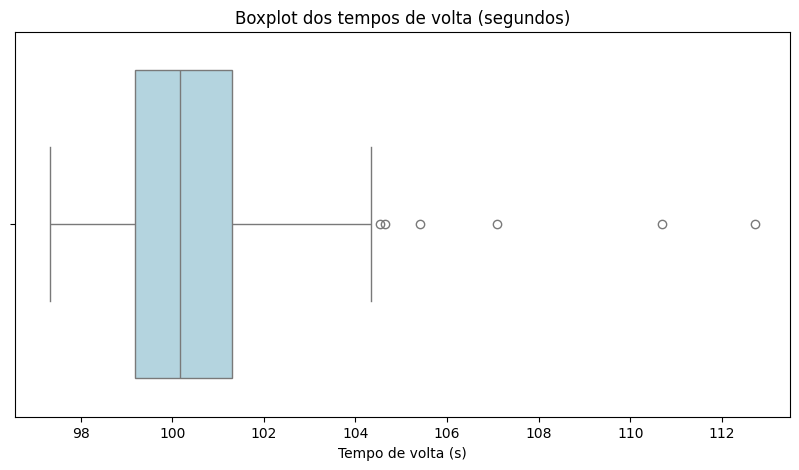

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.boxplot(x=df['LapTimeSeconds'], color='lightblue')
plt.title('Boxplot dos tempos de volta (segundos)')
plt.xlabel('Tempo de volta (s)')
plt.show()


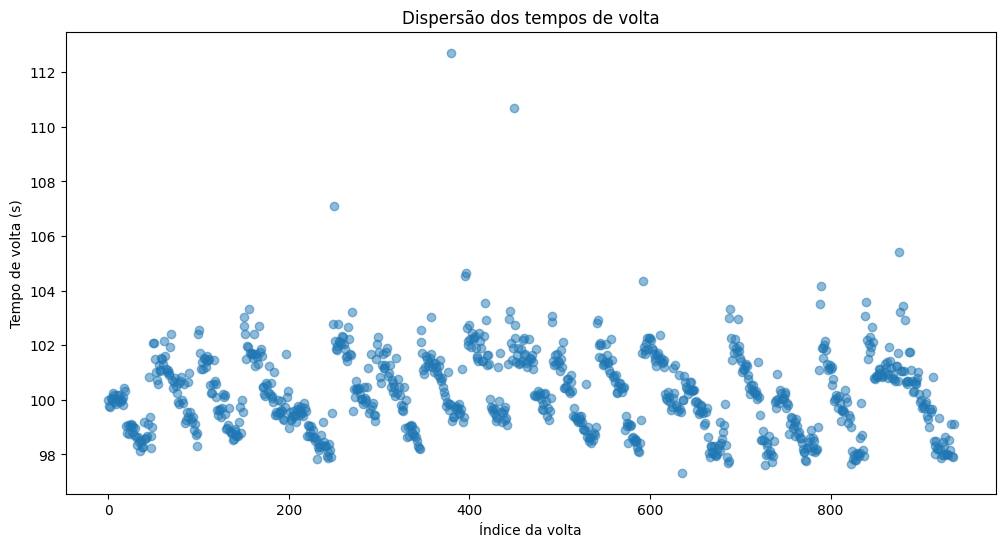

In [11]:
plt.figure(figsize=(12, 6))
plt.scatter(range(len(df)), df['LapTimeSeconds'], alpha=0.5)
plt.title('Dispersão dos tempos de volta')
plt.xlabel('Índice da volta')
plt.ylabel('Tempo de volta (s)')
plt.show()


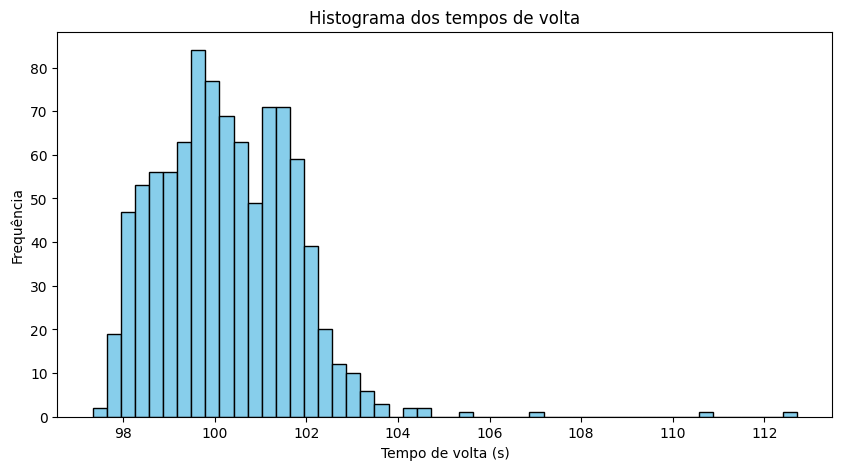

In [12]:
plt.figure(figsize=(10, 5))
plt.hist(df['LapTimeSeconds'], bins=50, color='skyblue', edgecolor='black')
plt.title('Histograma dos tempos de volta')
plt.xlabel('Tempo de volta (s)')
plt.ylabel('Frequência')
plt.show()


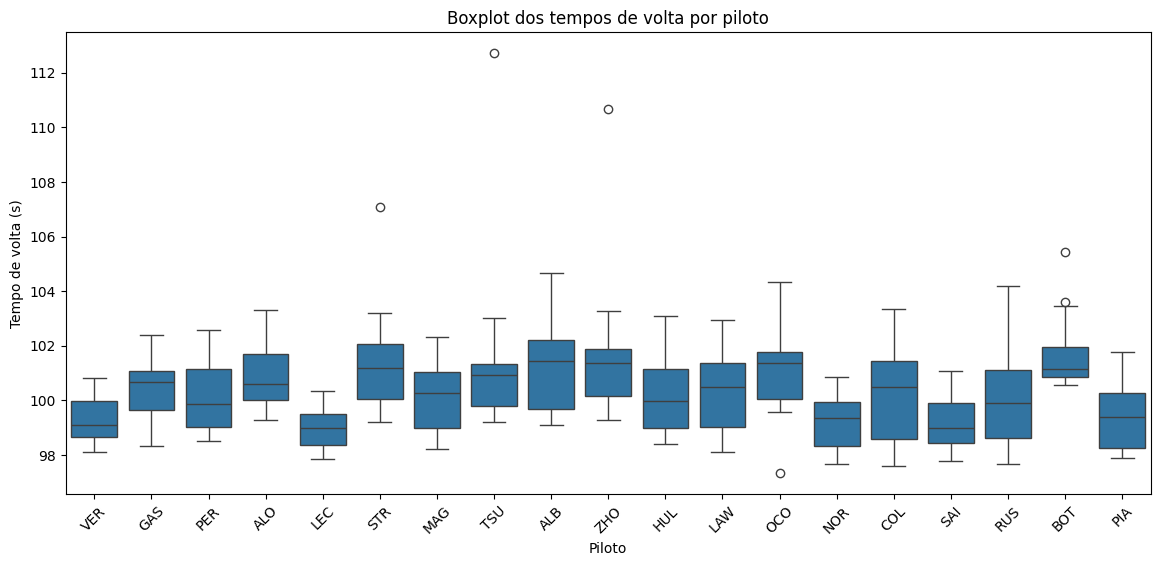

In [13]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='Driver', y='LapTimeSeconds', data=df)
plt.title('Boxplot dos tempos de volta por piloto')
plt.xlabel('Piloto')
plt.ylabel('Tempo de volta (s)')
plt.xticks(rotation=45)
plt.show()


In [14]:
menor_volta_por_piloto = df.groupby('Driver')['LapTime'].min().sort_values()
print(menor_volta_por_piloto)


Driver
OCO   0 days 00:01:37.330000
COL   0 days 00:01:37.611000
RUS   0 days 00:01:37.656000
NOR   0 days 00:01:37.679000
SAI   0 days 00:01:37.763000
LEC   0 days 00:01:37.834000
PIA   0 days 00:01:37.883000
LAW   0 days 00:01:38.091000
VER   0 days 00:01:38.117000
MAG   0 days 00:01:38.210000
GAS   0 days 00:01:38.311000
HUL   0 days 00:01:38.404000
PER   0 days 00:01:38.514000
ALB   0 days 00:01:39.084000
TSU   0 days 00:01:39.193000
STR   0 days 00:01:39.214000
ALO   0 days 00:01:39.261000
ZHO   0 days 00:01:39.272000
BOT   0 days 00:01:40.575000
Name: LapTime, dtype: timedelta64[ns]


In [15]:
year = 2024
grand_prix = 'Estados Unidos'
race_date = '2024-10-20'  # ex: usar o dado do evento ou da sessão

# Calcular métricas por piloto (como antes)
consistency_df = df.groupby('Driver')['LapTimeSeconds'].agg([
    'count',
    'mean',
    'std',
    'min',
    'max',
    'median'
]).rename(columns={
    'count': 'NumVoltas',
    'mean': 'MediaTempo',
    'std': 'DesvioPadrao',
    'min': 'MelhorVolta',
    'max': 'PiorVolta',
    'median': 'MedianaTempo'
})

consistency_df['RangeTempo'] = consistency_df['PiorVolta'] - consistency_df['MelhorVolta']

# Adicionar colunas fixas
consistency_df['Year'] = year
consistency_df['GrandPrix'] = grand_prix
consistency_df['RaceDate'] = race_date

# Resetar índice para 'Driver' virar coluna normal
consistency_df = consistency_df.reset_index()


In [16]:
consistency_df

,Driver,NumVoltas,MediaTempo,DesvioPadrao,MelhorVolta,PiorVolta,MedianaTempo,RangeTempo,Year,GrandPrix,RaceDate
0,ALB,49,101.192592,1.452484,99.084,104.652,101.4320,5.568,2024,Estados Unidos,2024-10-20
1,ALO,49,100.900347,1.101841,99.261,103.326,100.6100,4.065,2024,Estados Unidos,2024-10-20
2,BOT,49,101.496980,0.979938,100.575,105.416,101.1380,4.841,2024,Estados Unidos,2024-10-20
3,COL,50,100.317120,1.577893,97.611,103.338,100.4930,5.727,2024,Estados Unidos,2024-10-20
4,GAS,50,100.499840,1.007197,98.311,102.407,100.6850,4.096,2024,Estados Unidos,2024-10-20
5,HUL,50,100.093760,1.248925,98.404,103.090,99.9780,4.686,2024,Estados Unidos,2024-10-20
6,LAW,50,100.278800,1.383116,98.091,102.925,100.5035,4.834,2024,Estados Unidos,2024-10-20
7,LEC,50,98.941140,0.631500,97.834,100.341,98.9915,2.507,2024,Estados Unidos,2024-10-20
8,MAG,48,100.115500,1.173763,98.210,102.311,100.2710,4.101,2024,Estados Unidos,2024-10-20
9,NOR,50,99.203360,0.980651,97.679,100.864,99.3340,3.185,2024,Estados Unidos,2024-10-20


In [17]:
# Juntar os dois DataFrames pela coluna 'Driver'
df_final = consistency_df.merge(df_features, on='Driver', how='inner')


In [18]:
df_final

,Driver,NumVoltas,MediaTempo,DesvioPadrao,MelhorVolta,PiorVolta,MedianaTempo,RangeTempo,Year,GrandPrix,RaceDate,VoltasCompletadasDadosBrutos,Concluiu
0,ALB,49,101.192592,1.452484,99.084,104.652,101.4320,5.568,2024,Estados Unidos,2024-10-20,55.0,True
1,ALO,49,100.900347,1.101841,99.261,103.326,100.6100,4.065,2024,Estados Unidos,2024-10-20,55.0,True
2,BOT,49,101.496980,0.979938,100.575,105.416,101.1380,4.841,2024,Estados Unidos,2024-10-20,55.0,True
3,COL,50,100.317120,1.577893,97.611,103.338,100.4930,5.727,2024,Estados Unidos,2024-10-20,56.0,True
4,GAS,50,100.499840,1.007197,98.311,102.407,100.6850,4.096,2024,Estados Unidos,2024-10-20,56.0,True
5,HUL,50,100.093760,1.248925,98.404,103.090,99.9780,4.686,2024,Estados Unidos,2024-10-20,56.0,True
6,LAW,50,100.278800,1.383116,98.091,102.925,100.5035,4.834,2024,Estados Unidos,2024-10-20,56.0,True
7,LEC,50,98.941140,0.631500,97.834,100.341,98.9915,2.507,2024,Estados Unidos,2024-10-20,56.0,True
8,MAG,48,100.115500,1.173763,98.210,102.311,100.2710,4.101,2024,Estados Unidos,2024-10-20,56.0,True
9,NOR,50,99.203360,0.980651,97.679,100.864,99.3340,3.185,2024,Estados Unidos,2024-10-20,56.0,True


In [19]:
df_pit_features

,Driver,NumParadasBox,VoltaPrimeiroPit,DuracaoMediaStint,PropVoltasMacios,PropVoltasMedios,PropVoltasDuros
0,ALB,2,4.0,18.333333,0.000000,0.600000,0.400000
1,ALO,1,27.0,27.500000,0.000000,0.472727,0.527273
2,BOT,1,16.0,27.500000,0.000000,0.272727,0.727273
3,COL,1,40.0,28.000000,0.000000,0.303571,0.696429
4,GAS,1,19.0,28.000000,0.000000,0.321429,0.678571
5,HAM,0,0.0,2.000000,0.000000,0.000000,1.000000
6,HUL,1,28.0,28.000000,0.000000,0.482143,0.517857
7,LAW,1,37.0,28.000000,0.000000,0.357143,0.642857
8,LEC,1,27.0,28.000000,0.000000,0.464286,0.535714
9,MAG,2,18.0,18.666667,0.000000,0.625000,0.375000


In [20]:
df_completo = df_final.merge(df_pit_features, on='Driver', how='inner')


In [21]:
df_completo

,Driver,NumVoltas,MediaTempo,DesvioPadrao,MelhorVolta,PiorVolta,MedianaTempo,RangeTempo,Year,GrandPrix,RaceDate,VoltasCompletadasDadosBrutos,Concluiu,NumParadasBox,VoltaPrimeiroPit,DuracaoMediaStint,PropVoltasMacios,PropVoltasMedios,PropVoltasDuros
0,ALB,49,101.192592,1.452484,99.084,104.652,101.4320,5.568,2024,Estados Unidos,2024-10-20,55.0,True,2,4.0,18.333333,0.000000,0.600000,0.400000
1,ALO,49,100.900347,1.101841,99.261,103.326,100.6100,4.065,2024,Estados Unidos,2024-10-20,55.0,True,1,27.0,27.500000,0.000000,0.472727,0.527273
2,BOT,49,101.496980,0.979938,100.575,105.416,101.1380,4.841,2024,Estados Unidos,2024-10-20,55.0,True,1,16.0,27.500000,0.000000,0.272727,0.727273
3,COL,50,100.317120,1.577893,97.611,103.338,100.4930,5.727,2024,Estados Unidos,2024-10-20,56.0,True,1,40.0,28.000000,0.000000,0.303571,0.696429
4,GAS,50,100.499840,1.007197,98.311,102.407,100.6850,4.096,2024,Estados Unidos,2024-10-20,56.0,True,1,19.0,28.000000,0.000000,0.321429,0.678571
5,HUL,50,100.093760,1.248925,98.404,103.090,99.9780,4.686,2024,Estados Unidos,2024-10-20,56.0,True,1,28.0,28.000000,0.000000,0.482143,0.517857
6,LAW,50,100.278800,1.383116,98.091,102.925,100.5035,4.834,2024,Estados Unidos,2024-10-20,56.0,True,1,37.0,28.000000,0.000000,0.357143,0.642857
7,LEC,50,98.941140,0.631500,97.834,100.341,98.9915,2.507,2024,Estados Unidos,2024-10-20,56.0,True,1,27.0,28.000000,0.000000,0.464286,0.535714
8,MAG,48,100.115500,1.173763,98.210,102.311,100.2710,4.101,2024,Estados Unidos,2024-10-20,56.0,True,2,18.0,18.666667,0.000000,0.625000,0.375000
9,NOR,50,99.203360,0.980651,97.679,100.864,99.3340,3.185,2024,Estados Unidos,2024-10-20,56.0,True,1,32.0,28.000000,0.000000,0.553571,0.446429


In [22]:
print("Shape final:", df_completo.shape)
print("Pilotos presentes:", df_completo['Driver'].nunique())


Shape final: (19, 19)
Pilotos presentes: 19


In [23]:
df_completo.to_csv('df_completoEstadosUnidos.csv', index=False)
